In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('jaq', 1, 2) # animal, day, epoch

In [5]:
from src.load_data import load_data

data = load_data(epoch_key)

INFO:src.load_data:Loading position information and linearizing...
INFO:src.load_data:Loading multiunits...


In [6]:
from replay_trajectory_classification import ClusterlessDecoder

decoder = ClusterlessDecoder(transition_type='empirical_movement', replay_speed=40, place_bin_size=5)

In [7]:
decoder.fit(
    position=data['position_info'].linear_position,
    multiunits=data['multiunits'],
    is_training=data['position_info'].speed > 4)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=5, position_range=None, replay_speed=40,
                   transition_type='empirical_movement')

In [8]:
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()

In [9]:
place_bin_centers = decoder.place_bin_centers_

max_min_segment = data['position_info'].groupby('track_segment_id').linear_position.aggregate(['min', 'max'])
max_min_segment

,min,max
track_segment_id,,
0.0,2.228453e+02,239.722410
1.0,2.547224e+02,271.071505
2.0,1.908898e+02,207.845251
3.0,6.477570e+01,80.886877
4.0,1.598003e+02,175.889765
5.0,3.167302e+01,49.775705
6.0,8.881784e-16,16.673015
7.0,1.280609e+02,144.800268
8.0,9.588688e+01,113.060946


In [10]:
max_min_segment.diff(axis=1).dropna(axis=1)

,max
track_segment_id,
0.0,16.877159
1.0,16.349096
2.0,16.955486
3.0,16.111172
4.0,16.089497
5.0,18.102689
6.0,16.673015
7.0,16.739322
8.0,17.174069


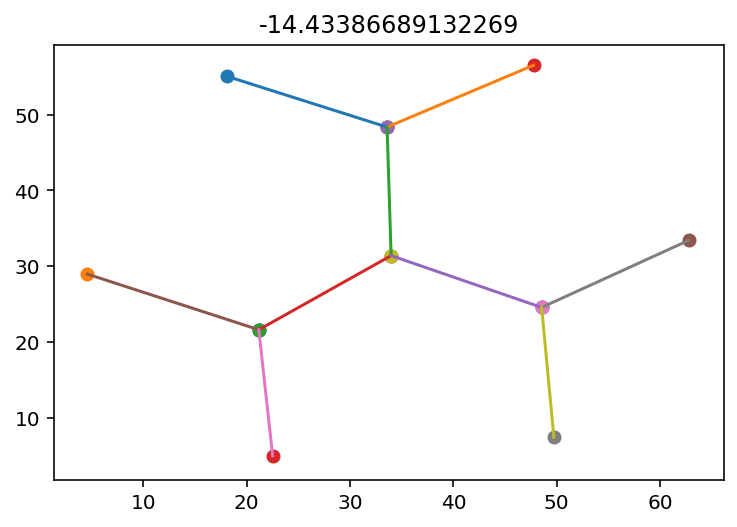

In [11]:
for node1, node2 in track_graph.edges:
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
    slope = (node2_y_pos - node1_y_pos) / (node2_x_pos - node1_x_pos)

    plt.scatter(node1_x_pos, node1_y_pos)
    plt.scatter(node2_x_pos, node2_y_pos)
    plt.plot((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    plt.title(slope)

In [12]:
np.diff(decoder.place_bin_edges_, axis=0)[0, 0]

4.928572821158055

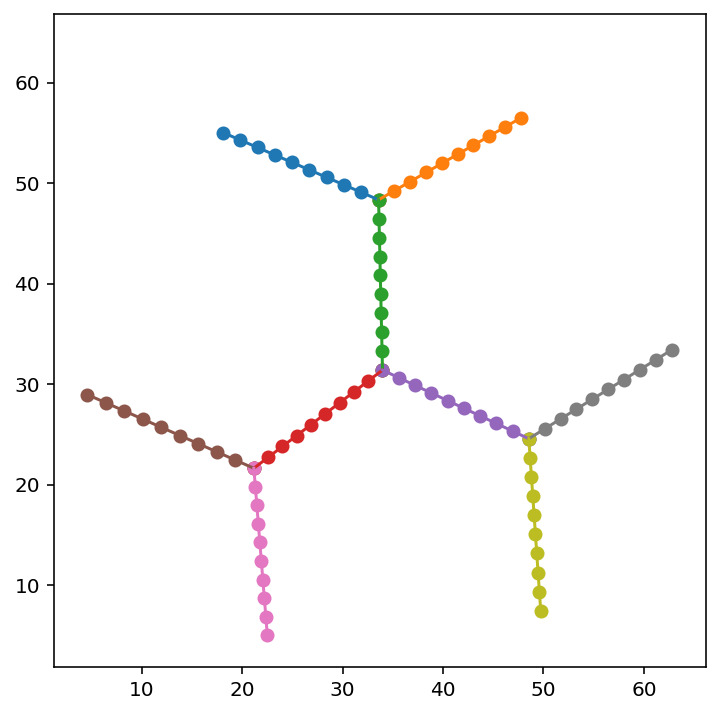

In [175]:
from scipy.interpolate import interp1d

plt.figure(figsize=(7, 6))

points = []
track_segment_id = []

for edge_ind, (node1, node2) in enumerate(track_graph.edges):
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
    f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    xnew = np.linspace(node1_x_pos, node2_x_pos, num=10, endpoint=True)    
    distance_between_nodes = np.linalg.norm(
        (node2_x_pos - node1_x_pos, node2_y_pos - node1_y_pos))
    xy = np.stack((xnew, f(xnew)), axis=1)
    
    points.append(xy)
    track_segment_id.append(np.ones_like(xnew) * edge_ind)
    
#     print(np.linalg.norm(np.diff(xy, axis=0), axis=1))
    plt.plot((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    plt.scatter(xnew, f(xnew))
    
plt.axis('square');

In [45]:
points = np.concatenate(points)
track_segment_id = np.concatenate(track_segment_id)

In [204]:
# points, unique_ind = np.unique(points, return_index=True, axis=0)
# track_segment_id = track_segment_id[unique_ind]

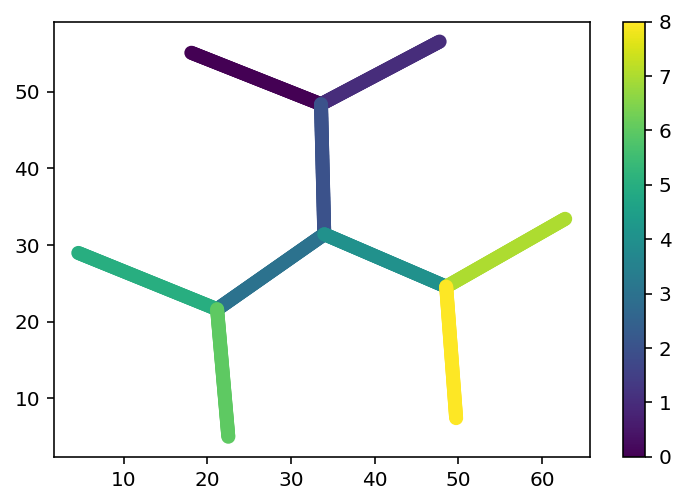

In [92]:
plt.scatter(points[:, 0], points[:, 1], c=track_segment_id)
plt.colorbar()

In [163]:
from loren_frank_data_processing.track_segment_classification import calculate_linear_distance

linear_distance = calculate_linear_distance(track_graph, track_segment_id, center_well_id,
                          points)

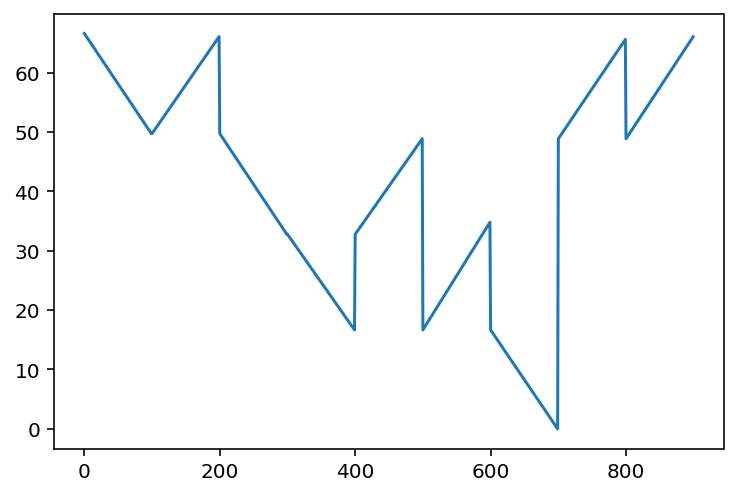

In [48]:
plt.plot(linear_distance)

In [49]:
from src.load_data import convert_linear_distance_to_linear_position

EDGE_ORDER = [6, 5, 3, 8, 7, 4, 2, 0, 1]

linear_position = convert_linear_distance_to_linear_position(
    linear_distance,
    track_segment_id, EDGE_ORDER, spacing=15)

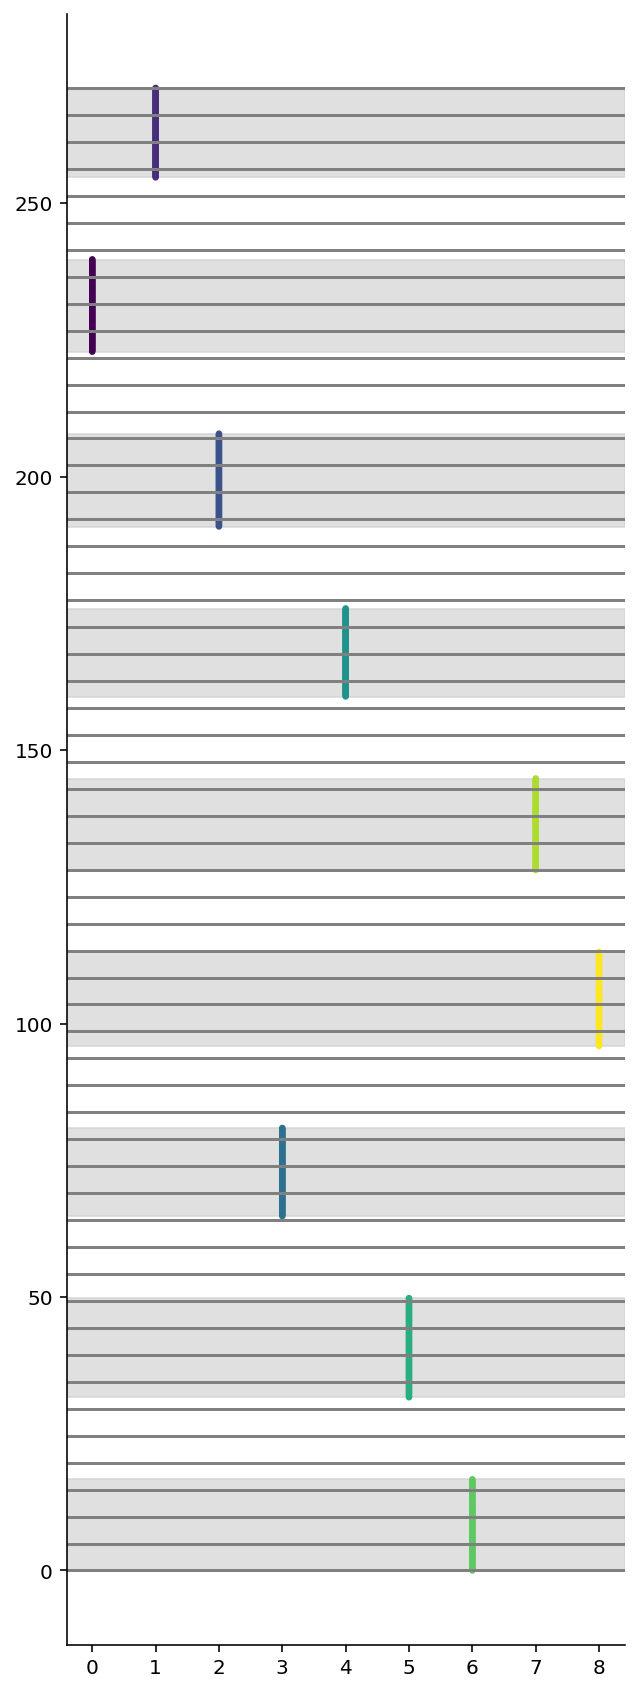

In [112]:
import seaborn as sns

plt.figure(figsize=(5, 15))
plt.scatter(track_segment_id, linear_position, s=5, c=track_segment_id)

for id, df in max_min_segment.iterrows():
    plt.axhspan(df['min'], df['max'], color='lightgrey', alpha=0.7, zorder=-1)
    
# for center in decoder.place_bin_centers_[decoder.is_track_interior_]:
#     plt.axhline(center, color='grey')
for e in decoder.place_bin_edges_:
    plt.axhline(e, color='grey')
    
sns.despine()

In [64]:
np.histogram(linear_position, bins=decoder.place_bin_edges_.squeeze())[0][decoder.is_track_interior_]

array([30, 29, 29, 12, 16, 27, 27, 27,  3, 26, 31, 30, 13, 16, 28, 29, 27,
        1, 29, 29, 29, 12, 18, 30, 30, 22,  8, 29, 29, 28,  6, 23, 29, 29,
       19, 10, 30, 29, 30])

In [74]:
np.digitize(linear_position, bins=decoder.place_bin_edges_.squeeze(), right=True)

array([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 43, 43, 43, 43,
       43, 43, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42

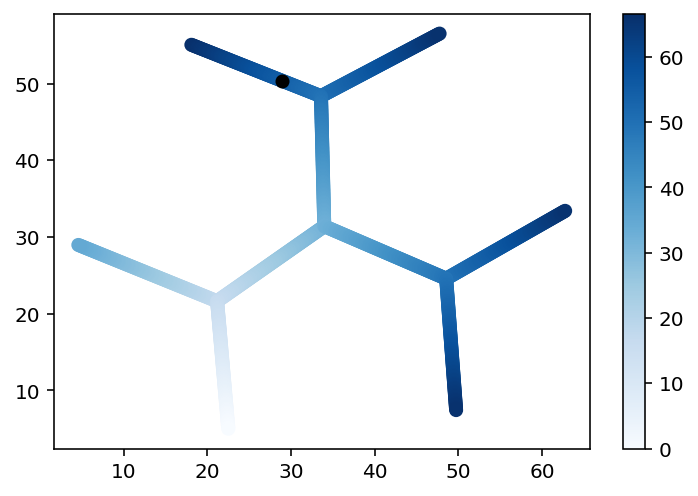

In [98]:
plt.scatter(points[:, 0], points[:, 1], c=np.abs(linear_distance), cmap='Blues')
plt.colorbar()
plt.scatter(points[69, 0], points[69, 1], color='black')

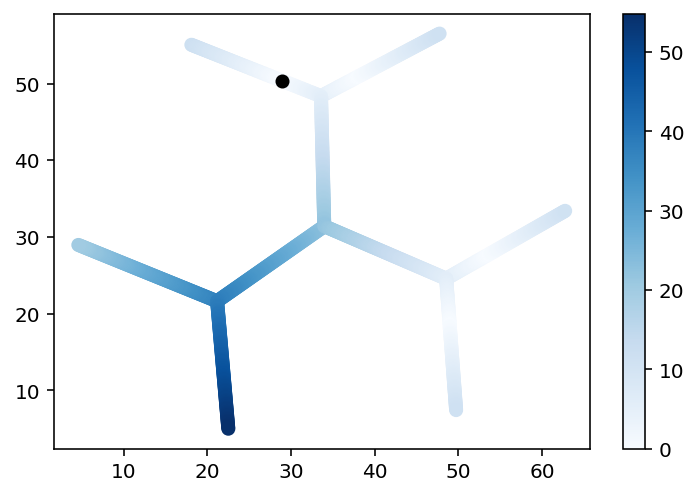

In [140]:
plt.scatter(points[:, 0], points[:, 1], c=np.abs(linear_distance - linear_distance[69]), cmap='Blues')
plt.colorbar()
plt.scatter(points[69, 0], points[69, 1], color='black')

In [86]:
import pandas as pd

bin_ind = np.digitize(linear_position, bins=decoder.place_bin_edges_.squeeze()) - 1

np.nonzero(bin_ind == decoder.place_bin_centers_.size)

(array([199]),)

In [87]:
linear_position[199]

271.0997780023183

In [100]:
decoder.place_bin_edges_.max()

271.071505163693

In [89]:
points[199]

array([47.753, 56.512])

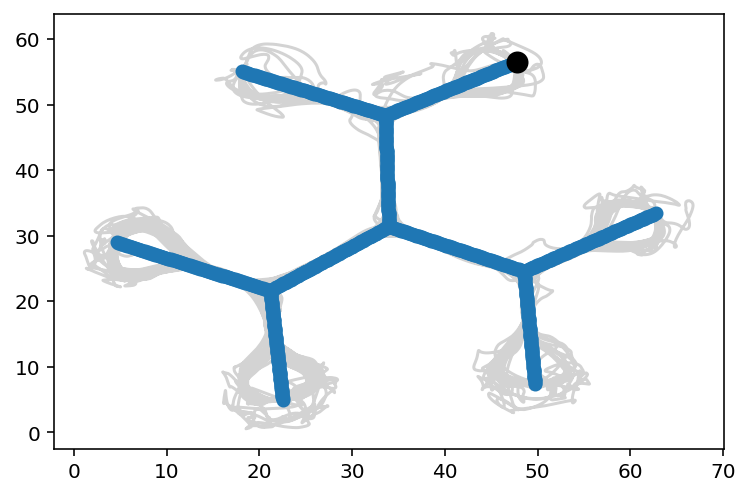

In [105]:
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(points[199, 0], points[199, 1], s=100, color='black', zorder=100)
plt.plot(data['position_info'].x_position, data['position_info'].y_position,
         color='lightgrey', zorder=0)

In [99]:
data['position_info'].linear_position.max()

271.071505163693

In [ ]:
d = pd.DataFrame(linear_distance).groupby(bin_ind).mean()
# d.set_index(decoder.place_bin_centers_[decoder.is_track_interior_].squeeze())
d

In [60]:
decoder.place_bin_centers_.shape

(55, 1)

In [72]:
d.shape

(40, 1)

In [73]:
decoder.place_bin_centers_[decoder.is_track_interior_].shape

(39, 1)

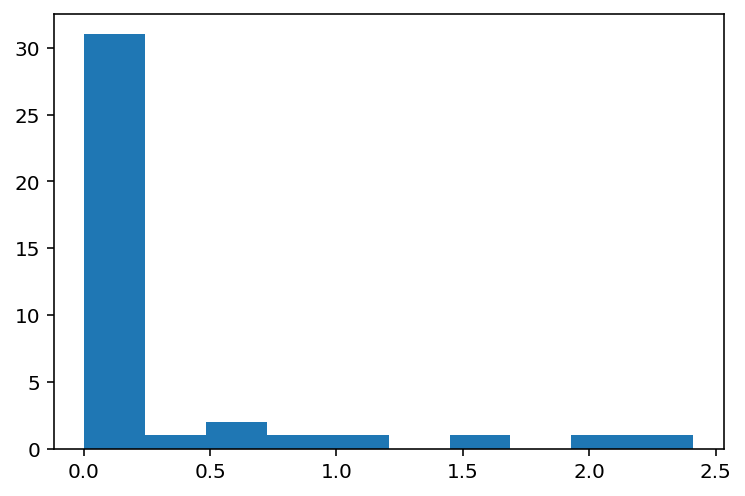

In [134]:
bin_points_dist = [np.min(np.abs(linear_position - bin_center))
                   for bin_center in decoder.place_bin_centers_[decoder.is_track_interior_]]

bin_points_ind = [np.argmin(np.abs(linear_position - bin_center))
                  for bin_center in decoder.place_bin_centers_[decoder.is_track_interior_]]
plt.hist(bin_points_dist);

(array([34.,  2.,  2.,  2.,  2.,  2.,  3.,  4.,  2.,  2.]),
 array([2.51265376e-03, 7.36179891e-01, 1.46984713e+00, 2.20351437e+00,
        2.93718160e+00, 3.67084884e+00, 4.40451608e+00, 5.13818332e+00,
        5.87185056e+00, 6.60551779e+00, 7.33918503e+00]),
 <a list of 10 Patch objects>)

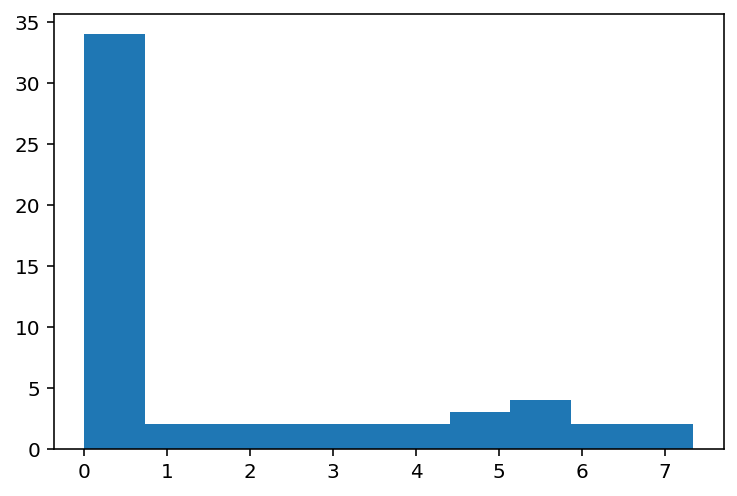

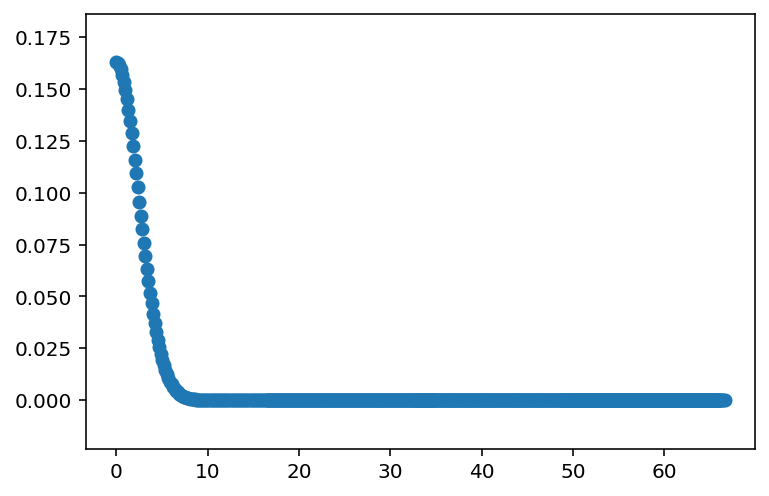

In [146]:
from scipy.stats import multivariate_normal

replay_speed = 1
movement_var = 6

gaussian = multivariate_normal(
        mean=0, cov=movement_var * replay_speed).pdf(
        linear_distance)

plt.scatter(linear_distance, gaussian)

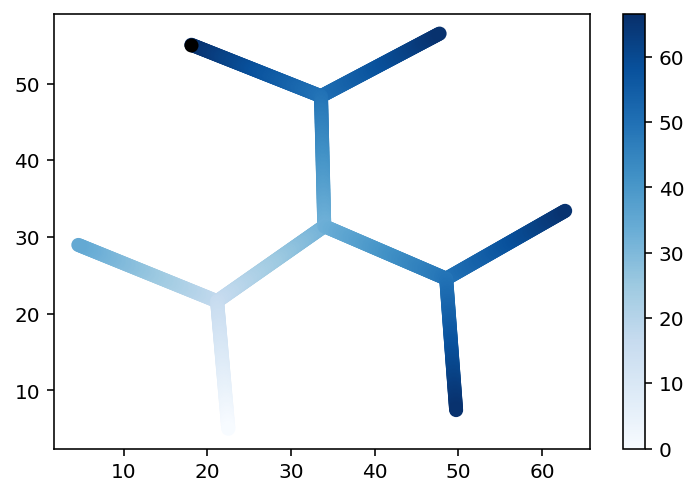

In [162]:
plt.scatter(points[:, 0], points[:, 1], c=linear_distance, cmap='Blues')
plt.colorbar()
plt.scatter(points[0, 0], points[0, 1], color='black')

In [172]:
import networkx as nx

dict(nx.all_pairs_dijkstra_path_length(track_graph, weight='distance'))

{0: {0: 0,
  1: 16.877158528614938,
  2: 33.22625406934746,
  3: 33.8326443960267,
  6: 49.92214134279294,
  4: 49.94381673077627,
  7: 66.6168321149232,
  9: 66.6614633123352,
  8: 67.09621069166889,
  5: 68.07477881225446},
 1: {1: 0,
  2: 16.349095540732524,
  0: 16.877158528614938,
  3: 16.955485867411763,
  6: 33.044982814178,
  4: 33.066658202161335,
  7: 49.73967358630826,
  9: 49.78430478372026,
  8: 50.21905216305394,
  5: 51.19762028363952},
 2: {2: 0,
  1: 16.349095540732524,
  0: 33.22625406934746,
  3: 33.30458140814429,
  6: 49.39407835491052,
  4: 49.415753742893855,
  7: 66.08876912704078,
  9: 66.13340032445278,
  8: 66.56814770378645,
  5: 67.54671582437204},
 3: {3: 0,
  6: 16.089496946766236,
  4: 16.11117233474957,
  1: 16.955485867411763,
  7: 32.78418771889649,
  9: 32.82881891630849,
  8: 33.26356629564218,
  2: 33.30458140814429,
  0: 33.8326443960267,
  5: 34.242134416227756},
 4: {4: 0,
  3: 16.11117233474957,
  7: 16.67301538414692,
  5: 18.13096208147819,
 

In [173]:
linear_distance.max()

66.6168321149232

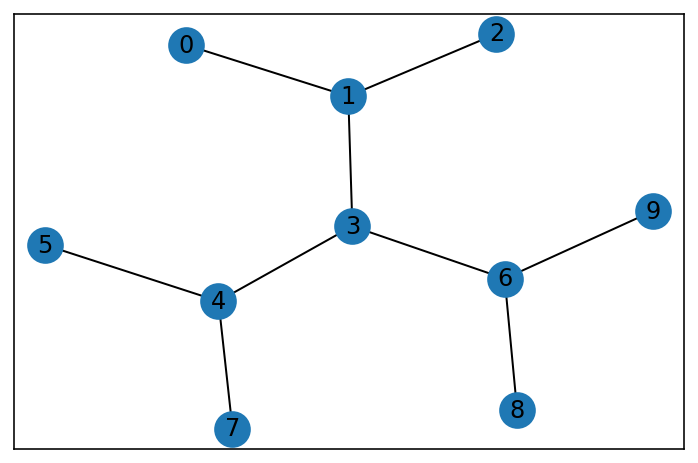

In [174]:
from loren_frank_data_processing.track_segment_classification import plot_track

plot_track(track_graph)

In [278]:
from scipy.interpolate import interp1d

track_graph1 = track_graph.copy()
n_nodes = len(track_graph.nodes)
bin_size = 2.5


for edge_ind, (node1, node2) in enumerate(track_graph.edges):
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
    f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    extent = np.linalg.norm((node2_x_pos - node1_x_pos, node2_y_pos - node1_y_pos))
    n_bins = 2 * np.ceil(extent / bin_size).astype(np.int) + 1
    xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)    
    xy = np.stack((xnew, f(xnew)), axis=1)
    dist = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    print(dist[0])
    new_node_ids = n_nodes + np.arange(len(dist))
    nx.add_path(track_graph1, [node1, *new_node_ids, node2], distance=dist[0])
    track_graph1.remove_edge(node1, node2)
    for id, pos in zip(new_node_ids, xy):
        track_graph1.nodes[id]['pos'] = pos
        track_graph1.nodes[id]['track_segment_id'] = edge_ind
    track_graph1.nodes[node1]['track_segment_id'] = edge_ind
    track_graph1.nodes[node2]['track_segment_id'] = edge_ind
    n_nodes = len(track_graph1.nodes)
    

1.2055113234724937
1.167792538623748
1.2111061333865956
1.1507980239106834
1.1492497819118734
1.1331851300923887
1.1909296702962089
1.1956658549673038
1.2267192392054387


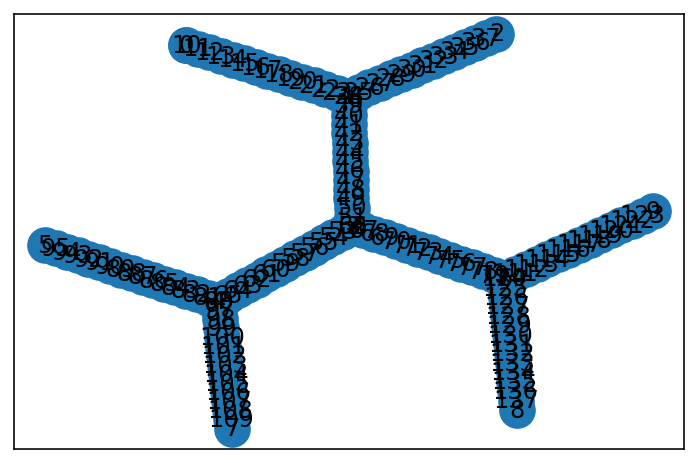

In [225]:
plot_track(track_graph1)

In [268]:
distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight='distance'))

In [228]:
dist[0] * 2

2.4534384784108774

In [226]:
n_nodes

138

In [279]:
node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
np.stack((node_ids, linear_distance), axis=1)

array([[  7.        ,   0.        ],
       [109.        ,   1.19092967],
       [108.        ,   2.38185934],
       [107.        ,   3.57278901],
       [106.        ,   4.76371868],
       [105.        ,   5.95464835],
       [104.        ,   7.14557802],
       [103.        ,   8.33650769],
       [102.        ,   9.52743736],
       [101.        ,  10.71836703],
       [100.        ,  11.9092967 ],
       [ 99.        ,  13.10022637],
       [ 98.        ,  14.29115604],
       [ 97.        ,  15.48208571],
       [ 96.        ,  16.67301538],
       [  4.        ,  17.86394505],
       [ 80.        ,  18.99713018],
       [ 65.        ,  19.01474308],
       [ 81.        ,  20.13031531],
       [ 64.        ,  20.1655411 ],
       [ 82.        ,  21.26350044],
       [ 63.        ,  21.31633913],
       [ 83.        ,  22.39668557],
       [ 62.        ,  22.46713715],
       [ 84.        ,  23.5298707 ],
       [ 61.        ,  23.61793517],
       [ 85.        ,  24.66305583],
 

In [287]:
ids = nx.get_node_attributes(track_graph1, 'track_segment_id')
track_segment_id = np.array([ids[node_id] for node_id in node_ids])
linear_distance = np.array(linear_distance)

In [288]:
linear_position = convert_linear_distance_to_linear_position(
    linear_distance,
    track_segment_id, EDGE_ORDER, spacing=15)

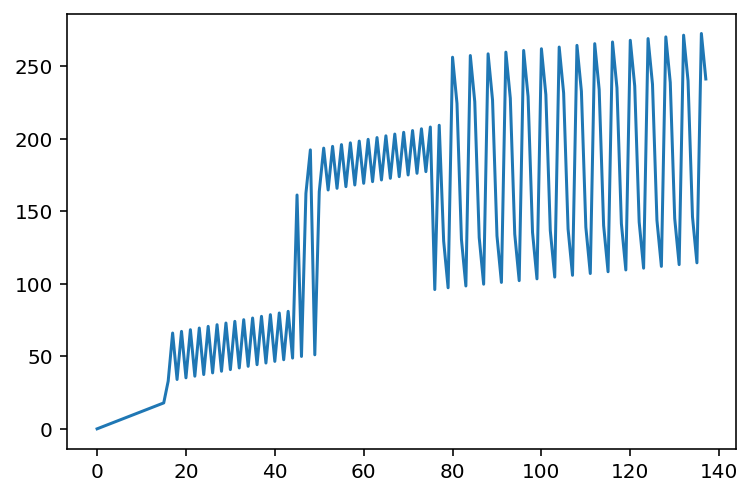

In [289]:
plt.plot(linear_position)

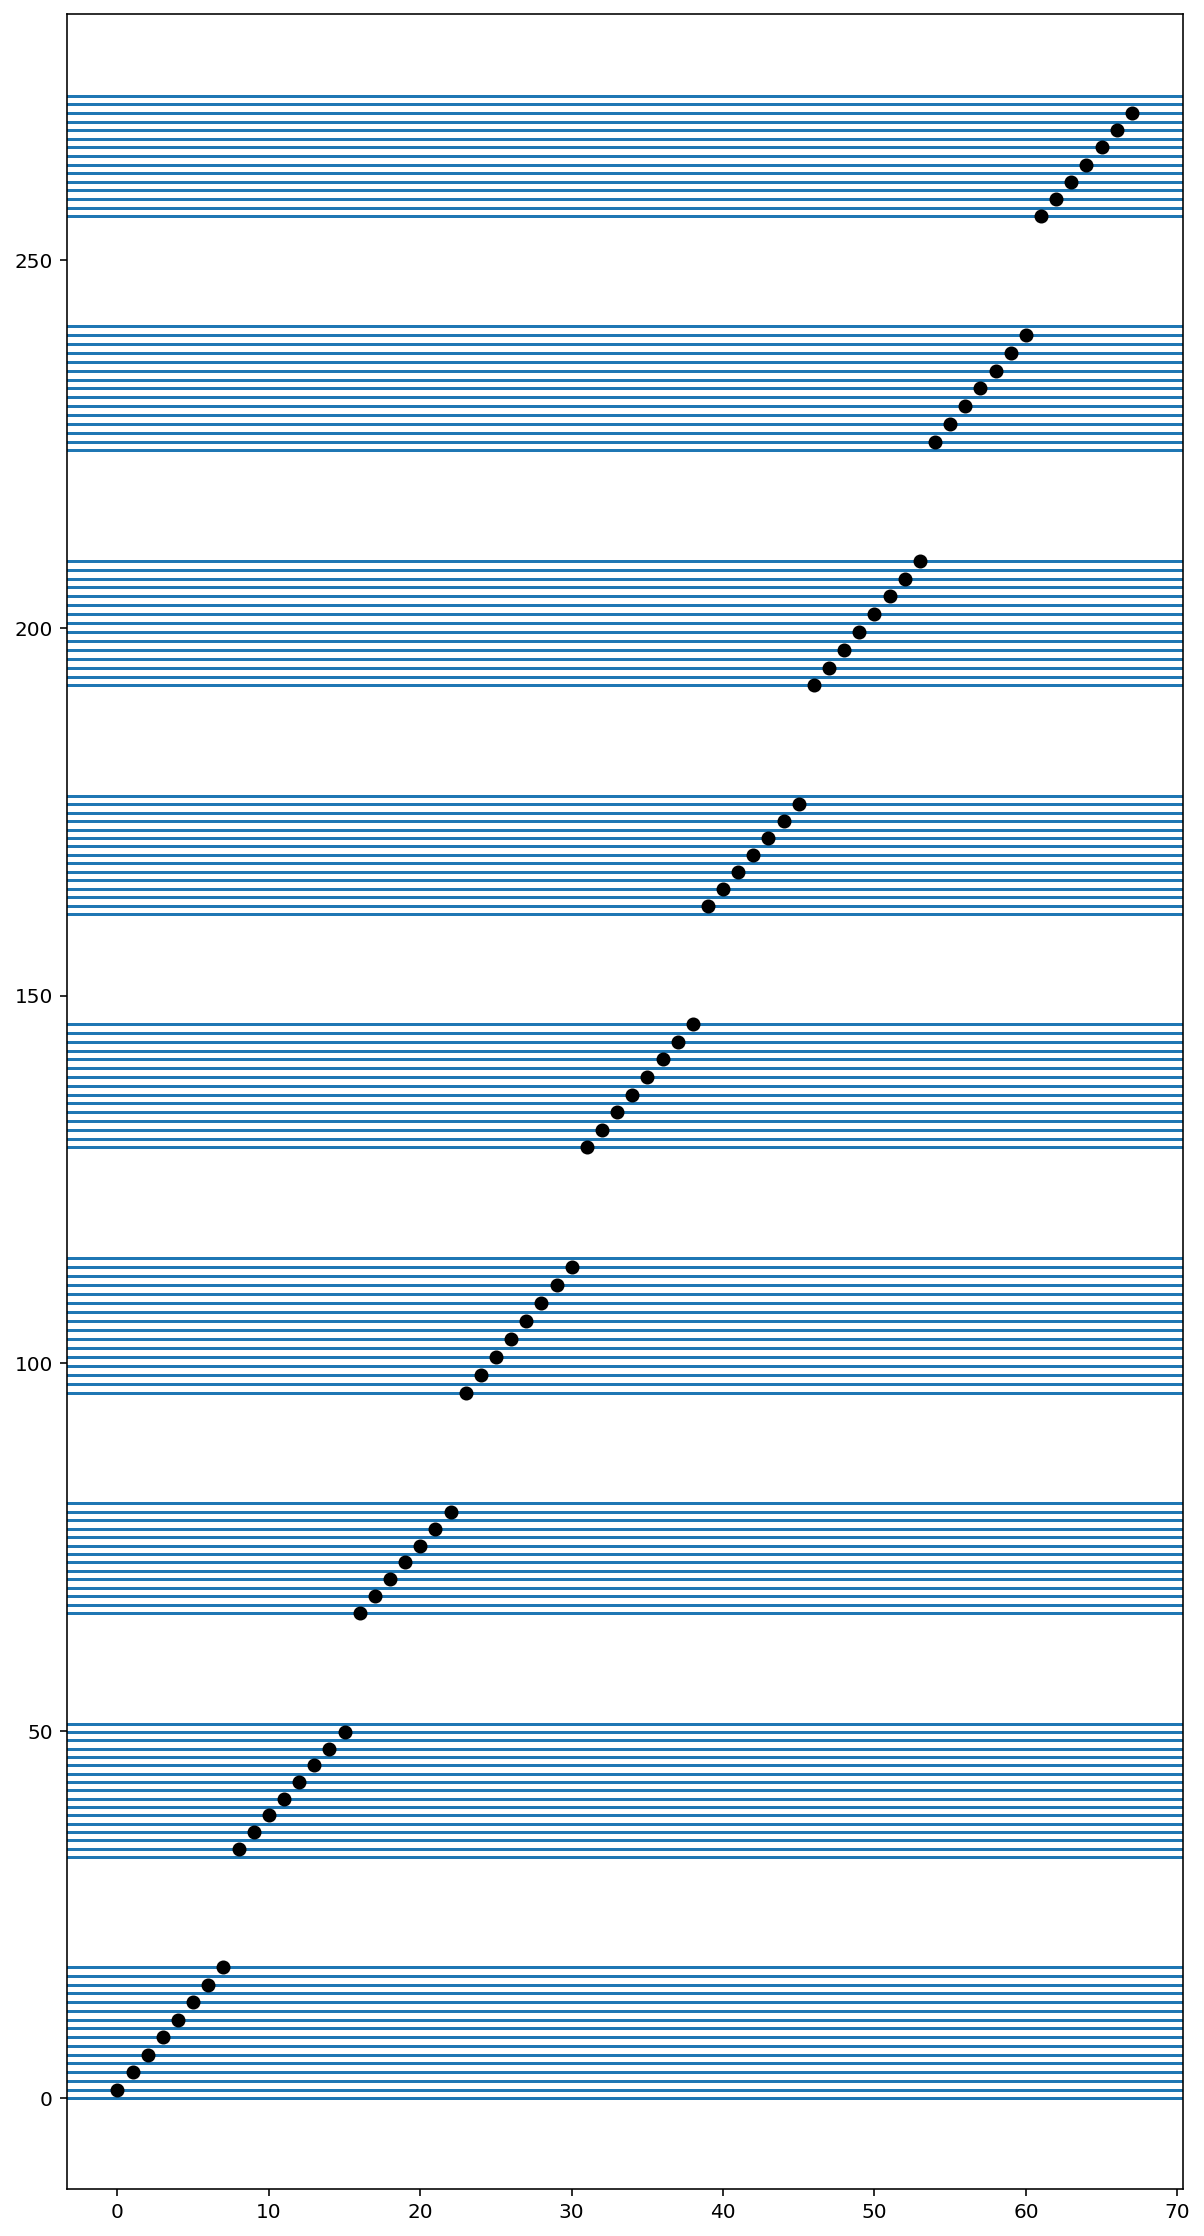

In [303]:

plt.figure(figsize=(10, 20))
# plt.scatter(np.arange(linear_position[1:-1:2].size), np.sort(linear_position)[1:-1:2],
#             zorder=100, color='black')
# for blah in np.sort(linear_position):
#     plt.axhline(blah)

pd.DataFrame([])

In [304]:
np.sort?

Signature: np.sort(a, axis=-1, kind=None, order=None)
Docstring:
Return a sorted copy of an array.

Parameters
----------
a : array_like
    Array to be sorted.
axis : int or None, optional
    Axis along which to sort. If None, the array is flattened before
    sorting. The default is -1, which sorts along the last axis.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort or radix sort under the covers and, in general,
    the actual implementation will vary with data type. The 'mergesort' option
    is retained for backwards compatibility.

    .. versionchanged:: 1.15.0.
       The 'stable' option was added.

order : str or list of str, optional
    When `a` is an array with fields defined, this argument specifies
    which fields to compare first, second, etc.  A single field can
    be specified as a string, and not all fields need be specified,
    but unspecif